In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T190052Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2e48419354d87c5e1ef11c0583b84a936cdd1c648a6fa42636b1194bf4587e6e7318969b8b0ca3b2b9896c1671d8c0603c820494c194e6016362a189977cc0d9083eb252301e1b10409f244f2dae0a85f7d7f90a4e4b54f1b852ea823c89104abb568aaa152af860f8ac6ab960ba5c5c7f15f1c27fd6c9dc249302dfbe774acb3a4f6ce30b2547d284d14d143aeed7c3cd9f3e5675b95fb540f5c80a2cc64593d022a2480143b5449052df18511c61f61950e28dff83289fe0bbf379292509df31b93f44ccb6369f65bbb5445ad9eec397378c6fa5c0867880d9bf32d7993b130f2c396bc421c552492a9b232aa93f51769f8c8d3340006ea36978715734bdb2,ravdess-emotional-song-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107666%2F256774%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T190052Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db1d449cc5ce29b0c163046addd0eba7adac516afe9d686b56aaaa326498b319fe427b39208d0f9edf898800086bdeeef7b72c3f226d1674e454faa30d8b32f3dacb06cacbcee383de363d164750167a4845d45f20e2c61fbecb13a5938da182da0d37d5b981d9dcbd3177e5100a803bcca93efd097297c2b4c63674e794db98b30d710709ed3dec4b15de7d79d7c5e9986dd29fa5e82a0710a2e438a745589bbd1b9f9d44ac188ef680ee2841e025ef3141fcc33aec6b007e62f1b3a47f56b40672a0ed5e6ad0296b063bc82ec8d28899a25887b6927dd1b8258bbc76c9e27262f32b2022059e7c96fd729c7dc9fb6de2a78285ebe20d56d6fa9310a8a7b7288,toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T190052Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D41a94ad0de729599ff5d71b7de2e3ad1e5070de6ea335b011dd2c7bc639a0fc9bc5b6cf85849c0fe7b080c5fdabe3072d4f695cf2a81071f124fe516b0e037dbc06f7cc09fada51ce396bd69f3f856ee33e55d56456f6a84e1db34c657dd49db4dab9e849d76a59a05d74080692a1ddfb388b35210121bc93ffaf145110fa04e9837a776e3b4b3c0db5c670e2247f2b006f8f693257a09c90f4b3dfd0e12a2ab74e02cd34b157b3f2b959f148b08ddd77e06cdef689f0c0c23f5e9575f40d219ae663370c16efde372d2178b9f673de18f8bb672856f99100037c0332bc0e8dd5f18b100da3bdd27bad8abfe6021c2aafc6f347f43a78ab65272a65ba8a06701,cremad:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F325566%2F653195%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T190052Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D85a8fbb3ee9483ebc183d7716cffb85ff73941319027e932e96cccb331dcabe70a9575d9bcba5a7cf3e83ce353918da6bde5c920e08201dc6b8d4ae57e171d288d0cb67d1c25b5b88d96ea52fc5dea83a56381a91550b1b35f2f26099516ef4a9bc455e460baae1a5c6bf8fb5a6107ae14f8565302098ca7b857f8a65db6a46f306cdda42118947e757c0ea4ceead95a6c4c8f338a9f9d44bd0ef9e918ed0cdf3cd8f0c1952433d7a6fe562be170f2d7f6e716b243c72befd5615b8d3304024d5f6c81ae35af430920c07d3e4638f0c5cb834711e68f776723a0caf49e0ef3af0aba165161e92182d903f7b73d6d185ea0a5b68bd12146dae164986476acaab8,surrey-audiovisual-expressed-emotion-savee:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F338555%2F671851%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T190052Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D40bec3e82ce5e6c70859707977a10d15749a6cad685d16cdf3525cadc9fa21d428649d2079099a35697bdd3ba934cc8c9dc747d144837777d683815afaf215b43a67a2ce4957d56679f4a90e833148d96bad37ac0edb87e877806a345983c5ad00171a11e916a20b655e28f445556243b158f09b72b5f22bcc361027061f092c47329467271faa2cc0520dcc6d70c100ea266179b250278a8ec940286f44b2e8396c0104a6bf53b1809f206c3e93a31f0f5b6b4632e83a7c807ce3e8f212947a1a60e932c269b9743210c388b3a3a6f589e7c01c6f01f2771639ff49bac32ed2f986fd74c79c9505b17642c68547cb7ff9b669f44c3612fd0e0330828031d658,features:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1156269%2F1938284%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T190052Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D899486ef21b234696a024370527c9ce25512320d9c8f8c2fd2b40d4bcddd0886cd8329f16ccbb3a591e554cbfcce34a1d559ac7923a92f5a32dfac9eb791249673b762206b6a3b7691aef88ee9e693b5b89c37eb1c0d4246101aa1da40066063a07d155fa7850553ef4b3c4fab277a1146f1968bd40a2a990813a98c649a1a6116c51a6658b5f0052cb814da635b93b9b1839018033185bf951a89095e2eaed7810b7467d0f277dfbe5e10a85c8fadae458a0407965bd95b7b49ab7f33dbe885546df8e8dd5797849ea3813eaa82616255f013713806c84cfbd59ca881c21a2115174c3596e18f7aa9c359a4b4646c1a0d0c35dd04df70dd5ad1b3dfe114f1f0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 450102890 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-speech-audio
[==================================================] 477641670 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-song-audio
[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
[==================================================] 473324524 bytes downloaded
Downloaded and uncompressed: cremad
[==================================================] 112690765 bytes downloaded
Downloaded and uncompressed: surrey-audiovisual-expressed-emotion-savee
[==================================================] 38593913 bytes downloaded
Downloaded and uncompressed: features
Data source import complete.


In [2]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# librosa is a Python library for analyzing audio and music.
# It can be used to extract the data from the audio files we will see it later
import librosa
import librosa.display

# to play the audio files
from IPython.display import Audio
plt.style.use('seaborn-white')
from scipy.signal import resample

<ipython-input-2-2f393a031fbb>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [3]:
DATA_FRAMES = True
fem_path = '../input/features/Female_features.csv'
mal_path = '../input/features/Male_features.csv'
#TESS - 2,800
TESS = "../input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
#RAVDESS - 2,076
RAV = "../input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
#SAVEE - 480
SAVEE = "../input/surrey-audiovisual-expressed-emotion-savee/ALL/"
#CREMA-D - 7,442
CREMA = "../input/cremad/AudioWAV/"

In [4]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry')
#     elif i[-8:-6]=='_d':
#         emotion.append('disgust')
#     elif i[-8:-6]=='_f':
#         emotion.append('fear')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
    elif i[-8:-6]=='sa':
        emotion.append('sad')
#     elif i[-8:-6]=='su':
#         emotion.append('surprise')
    else:
        emotion.append('unknown')
    path.append(SAVEE + i)

# # Now check out the label count distribution
# SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
# SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
# print('SAVEE dataset')
# SAVEE_df.head()
# Create DataFrame
SAVEE_df = pd.DataFrame({'labels': emotion, 'path': path})

# Filter out rows with labels not equal to 'unknown'
SAVEE_df = SAVEE_df[SAVEE_df['labels'] != 'unknown']

print('SAVEE dataset')
SAVEE_df.head()

SAVEE dataset


labels                                               path
2      sad  ../input/surrey-audiovisual-expressed-emotion-...
4  neutral  ../input/surrey-audiovisual-expressed-emotion-...
6  neutral  ../input/surrey-audiovisual-expressed-emotion-...
7      sad  ../input/surrey-audiovisual-expressed-emotion-...
9    angry  ../input/surrey-audiovisual-expressed-emotion-...

In [5]:
# Get the data location for TESS
path = []
emotion = []
dir_list = os.listdir(TESS)

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry')
#         elif i == 'OAF_disgust' or i == 'YAF_disgust':
#             emotion.append('disgust')
#         elif i == 'OAF_Fear' or i == 'YAF_fear':
#             emotion.append('fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral')
#         elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
#             emotion.append('surprise')
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)
TESS_df = pd.DataFrame({'labels': emotion, 'path': path})

# Filter out rows with labels not equal to 'Unknown'
TESS_df = TESS_df[TESS_df['labels'] != 'Unknown']

#TESS_df = pd.DataFrame(emotion, columns = ['labels'])
#TESS_df['source'] = 'TESS'
#TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
print('TESS dataset')
TESS_df.head()

TESS dataset


labels                                               path
0  happy  ../input/toronto-emotional-speech-set-tess/tes...
1  happy  ../input/toronto-emotional-speech-set-tess/tes...
2  happy  ../input/toronto-emotional-speech-set-tess/tes...
3  happy  ../input/toronto-emotional-speech-set-tess/tes...
4  happy  ../input/toronto-emotional-speech-set-tess/tes...

In [6]:
# Importing datas from RAVDESS
dir = os.listdir(RAV)

males = []
females = []

for actor in dir:

    files = os.listdir(RAV + actor)

    for file in files:
        part = file.split('.')[0]
        part = part.split("-")

        temp = int(part[6])

        if part[2] == '01':
            emotion = 'neutral'
        elif part[2] == '03':
            emotion = 'happy'
        elif part[2] == '04':
            emotion = 'sad'
        elif part[2] == '05':
            emotion = 'angry'
        else:
            emotion = 'unknown'

        if temp%2 == 0:
            path = (RAV + actor + '/' + file)
            #emotion = 'female_'+emotion
            females.append([emotion, path])
        else:
            path = (RAV + actor + '/' + file)
             #emotion = 'male_'+emotion
            males.append([emotion, path])


# Create DataFrames
RavFemales_df = pd.DataFrame(females, columns=['labels', 'path'])
RavMales_df = pd.DataFrame(males, columns=['labels', 'path'])

# Filter out rows with labels not equal to 'unknown'
RavFemales_df = RavFemales_df[RavFemales_df['labels'] != 'unknown']
RavMales_df = RavMales_df[RavMales_df['labels'] != 'unknown']

print('RAVDESS datasets - Females')
RavFemales_df.head()

RAVDESS datasets - Females


labels                                               path
0    happy  ../input/ravdess-emotional-speech-audio/audio_...
1    happy  ../input/ravdess-emotional-speech-audio/audio_...
2      sad  ../input/ravdess-emotional-speech-audio/audio_...
4    angry  ../input/ravdess-emotional-speech-audio/audio_...
6  neutral  ../input/ravdess-emotional-speech-audio/audio_...

In [7]:
print('\nRAVDESS datasets - Males')
RavMales_df.head()


RAVDESS datasets - Males


labels                                               path
0  happy  ../input/ravdess-emotional-speech-audio/audio_...
3    sad  ../input/ravdess-emotional-speech-audio/audio_...
4  happy  ../input/ravdess-emotional-speech-audio/audio_...
6    sad  ../input/ravdess-emotional-speech-audio/audio_...
7  happy  ../input/ravdess-emotional-speech-audio/audio_...

In [8]:
# Importing datas from RAVDESS
dir = os.listdir(RAV)

males = []
females = []

for actor in dir:

    files = os.listdir(RAV + actor)

    for file in files:
        part = file.split('.')[0]
        part = part.split("-")

        temp = int(part[6])

        if part[2] == '01':
            emotion = 'neutral'
#         elif part[2] == '02':
#             emotion = 'calm'
        elif part[2] == '03':
            emotion = 'happy'
        elif part[2] == '04':
            emotion = 'sad'
        elif part[2] == '05':
            emotion = 'angry'
#         elif part[2] == '06':
#             emotion = 'fear'
#         elif part[2] == '07':
#             emotion = 'disgust'
#         elif part[2] == '08':
#             emotion = 'surprise'
        else:
            emotion = 'unknown'

        if temp%2 == 0:
            path = (RAV + actor + '/' + file)
            #emotion = 'female_'+emotion
            females.append([emotion, path])
        else:
            path = (RAV + actor + '/' + file)
             #emotion = 'male_'+emotion
            males.append([emotion, path])


# RavFemales_df = pd.DataFrame(females)
# RavFemales_df.columns = ['labels', 'path']

# RavMales_df = pd.DataFrame(males)
# RavMales_df.columns = ['labels', 'path']

# print('RAVDESS datasets')
# RavFemales_df.head()
# Create DataFrames
RavFemales_df = pd.DataFrame(females, columns=['labels', 'path'])
RavMales_df = pd.DataFrame(males, columns=['labels', 'path'])

# Filter out rows with labels not equal to 'unknown'
RavFemales_df = RavFemales_df[RavFemales_df['labels'] != 'unknown']
RavMales_df = RavMales_df[RavMales_df['labels'] != 'unknown']

print('RAVDESS datasets - Females')
RavFemales_df.head()

RAVDESS datasets - Females


labels                                               path
0    happy  ../input/ravdess-emotional-speech-audio/audio_...
1    happy  ../input/ravdess-emotional-speech-audio/audio_...
2      sad  ../input/ravdess-emotional-speech-audio/audio_...
4    angry  ../input/ravdess-emotional-speech-audio/audio_...
6  neutral  ../input/ravdess-emotional-speech-audio/audio_...

In [9]:
print('\nRAVDESS datasets - Males')
RavMales_df.head()


RAVDESS datasets - Males


labels                                               path
0  happy  ../input/ravdess-emotional-speech-audio/audio_...
3    sad  ../input/ravdess-emotional-speech-audio/audio_...
4  happy  ../input/ravdess-emotional-speech-audio/audio_...
6    sad  ../input/ravdess-emotional-speech-audio/audio_...
7  happy  ../input/ravdess-emotional-speech-audio/audio_...

In [10]:
files = os.listdir(CREMA)

female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]
males = []
females = []

for file in files:
    part = file.split('_')

    if part[2] == 'SAD':
        emotion = 'sad'
    elif part[2] == 'ANG':
        emotion = 'angry'
#     elif part[2] == 'DIS':
#         emotion = 'disgust'
#     elif part[2] == 'FEA':
#         emotion = 'fear'
    elif part[2] == 'HAP':
        emotion = 'happy'
    elif part[2] == 'NEU':
        emotion = 'neutral'
    else:
        emotion = 'unknown'

    if int(part[0]) in female:
        path = (CREMA + '/' + file)
        #emotion = 'female_'+emotion
        females.append([emotion, path])
    else:
        path = (CREMA + '/' + file)
        #emotion = 'male_'+emotion
        males.append([emotion, path])

# CremaFemales_df = pd.DataFrame(females)
# CremaFemales_df.columns = ['labels', 'path']

# CremaMales_df = pd.DataFrame(males)
# CremaMales_df.columns = ['labels', 'path']

# print('CREMA datasets')
# CremaFemales_df.head()
# Create DataFrames
CremaFemales_df = pd.DataFrame(females, columns=['labels', 'path'])
CremaMales_df = pd.DataFrame(males, columns=['labels', 'path'])

# Filter out rows with labels not equal to 'unknown'
CremaFemales_df = CremaFemales_df[CremaFemales_df['labels'] != 'unknown']
CremaMales_df = CremaMales_df[CremaMales_df['labels'] != 'unknown']

print('CREMA datasets - Females')
CremaFemales_df.head()

CREMA datasets - Females


labels                                           path
0    happy  ../input/cremad/AudioWAV//1056_DFA_HAP_XX.wav
2    happy  ../input/cremad/AudioWAV//1010_TIE_HAP_XX.wav
4    happy  ../input/cremad/AudioWAV//1030_TAI_HAP_XX.wav
5  neutral  ../input/cremad/AudioWAV//1037_IEO_NEU_XX.wav
6      sad  ../input/cremad/AudioWAV//1078_ITS_SAD_XX.wav

In [11]:
print('\nCREMA datasets - Males')
CremaMales_df.head()


CREMA datasets - Males


labels                                           path
1     angry  ../input/cremad/AudioWAV//1064_MTI_ANG_XX.wav
4       sad  ../input/cremad/AudioWAV//1015_IEO_SAD_MD.wav
7   neutral  ../input/cremad/AudioWAV//1001_ITH_NEU_XX.wav
9     happy  ../input/cremad/AudioWAV//1042_ITS_HAP_XX.wav
10      sad  ../input/cremad/AudioWAV//1019_IEO_SAD_MD.wav

In [12]:
# Now lets merge all the dataframe
Males = pd.concat([SAVEE_df, RavMales_df, CremaMales_df], axis = 0)
Males.to_csv("males_emotions_df.csv", index = False)

Females = pd.concat([TESS_df, RavFemales_df, CremaFemales_df], axis = 0)
Females.to_csv("females_emotions_df.csv", index = False)

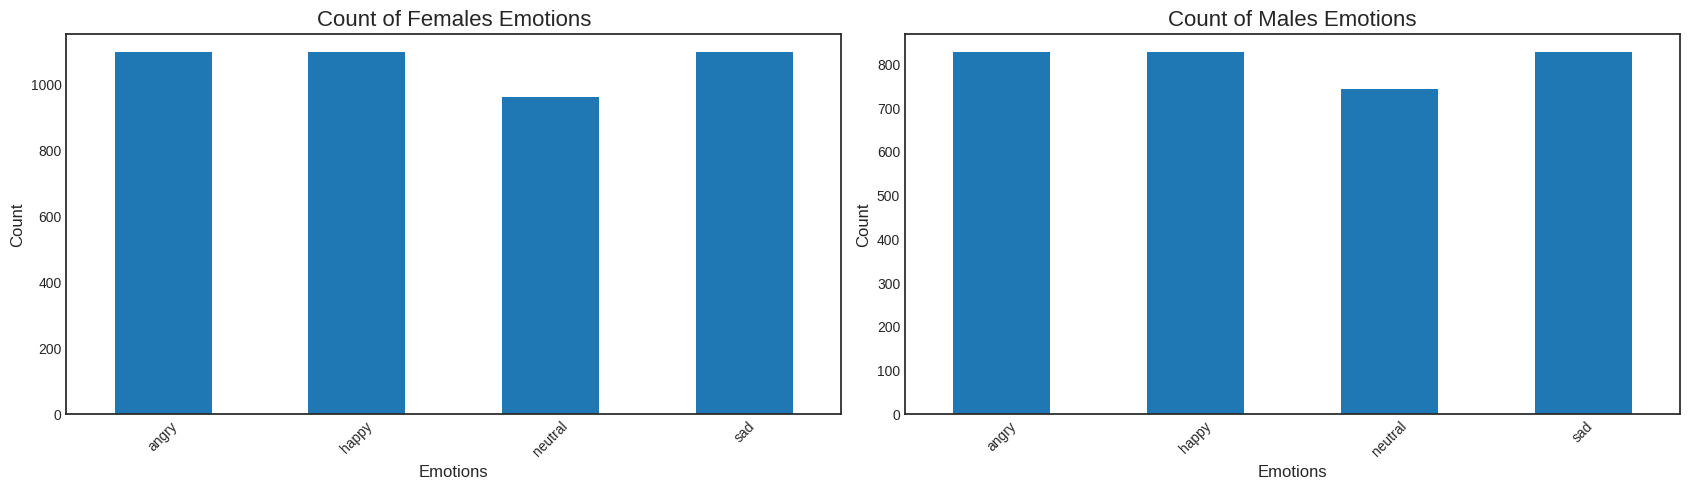

In [13]:
Females_labels_series = pd.Series(Females.labels)
Males_labels_series = pd.Series(Males.labels)

# Define the order of emotions
#order = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
order = ['angry', 'happy', 'neutral', 'sad']

# Create subplots
fig = plt.figure(figsize=(17, 5))

fig.add_subplot(121)
plt.title('Count of Females Emotions', size=16)
Females_labels_series.value_counts().loc[order].plot(kind='bar')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

fig.add_subplot(122)
plt.title('Count of Males Emotions', size=16)
Males_labels_series.value_counts().loc[order].plot(kind='bar')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

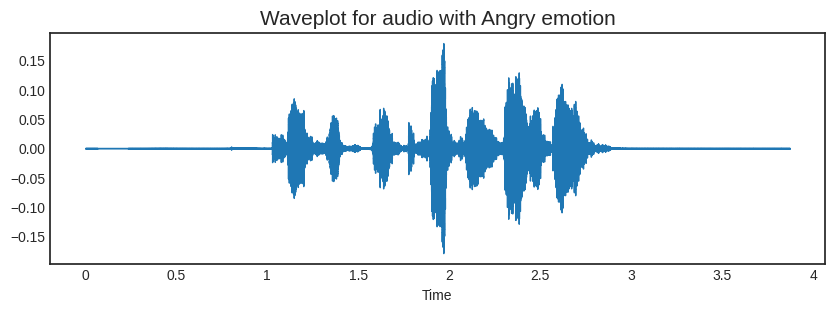

In [14]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
emotion = 'Angry'
path = '../input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
Audio(path)

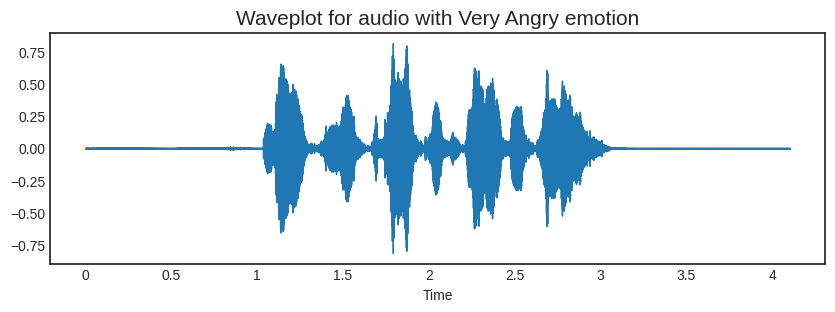

In [15]:
emotion='Very Angry'
path = '../input/ravdess-emotional-speech-audio/Actor_01/03-01-05-02-01-01-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
Audio(path)

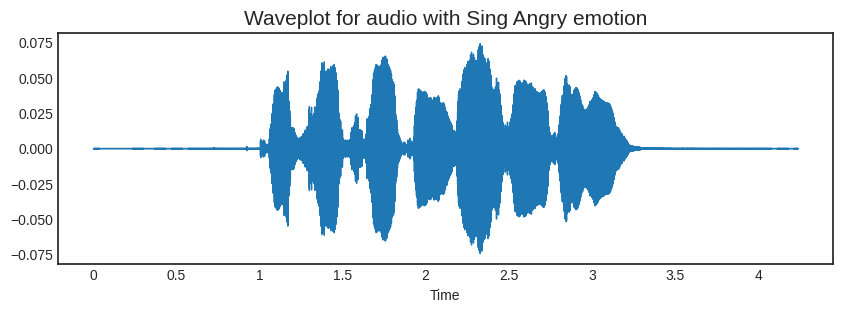

In [16]:
emotion='Sing Angry'
path = '../input/ravdess-emotional-song-audio/Actor_01/03-02-01-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
Audio(path)

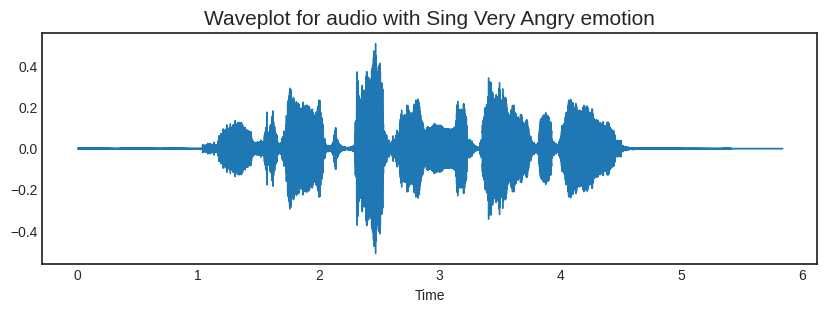

In [17]:
emotion='Sing Very Angry'
path = '../input/ravdess-emotional-song-audio/Actor_01/03-02-05-02-01-01-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
Audio(path)

In [18]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.8):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data, speed_factor)

def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data, speed_factor)

# taking any example and checking for techniques.
path = path = '../input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-01-01-01.wav'
data, sample_rate = librosa.load(path)

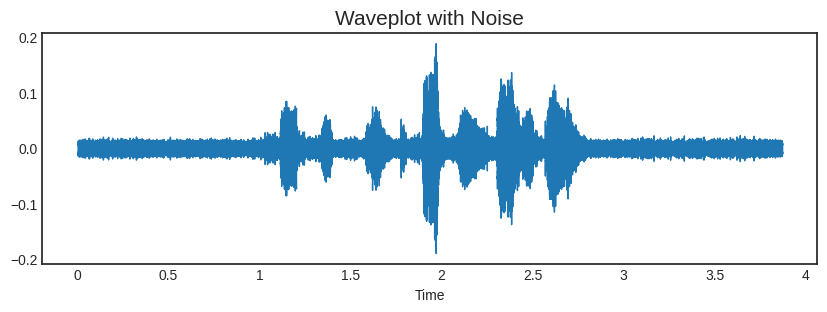

In [19]:
plt.figure(figsize=(10, 3))
x = noise(data)  # Applying noise to the data
y = resample(x, len(data))  # Resampling the noisy data to match original length
librosa.display.waveshow(y, sr=sample_rate)
plt.title('Waveplot with Noise', size=15)
plt.show()

# Playing the audio with added noise
Audio(y, rate=sample_rate)

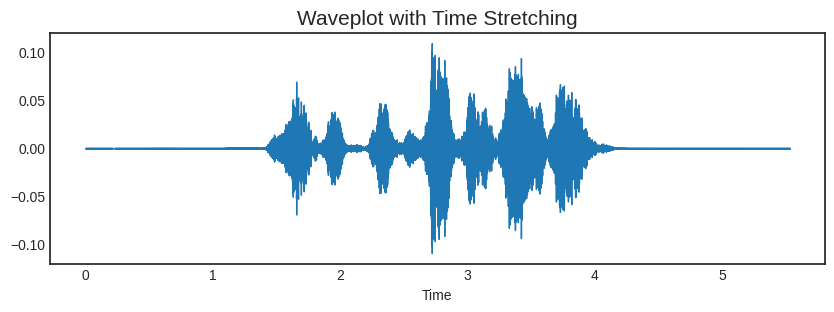

In [20]:
def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data, rate=rate)

plt.figure(figsize=(10, 3))
x = stretch(data)  # Assuming data is loaded or defined elsewhere
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Time Stretching', size=15)
plt.show()

# Playing the audio after time stretching
Audio(x, rate=sample_rate)

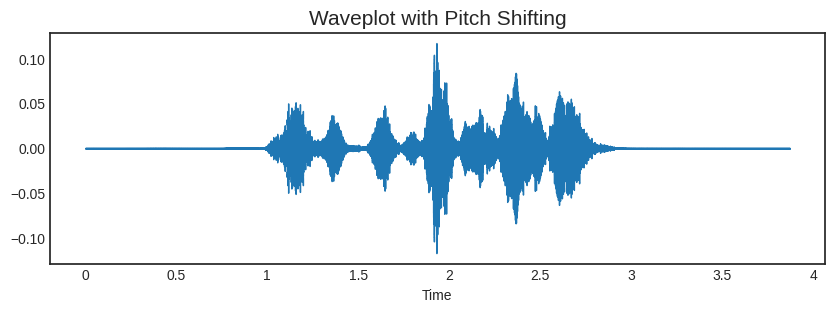

In [21]:
def shift(data, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=n_steps)

plt.figure(figsize=(10, 3))
x = shift(data)  # Assuming data is loaded or defined elsewhere
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Pitch Shifting', size=15)
plt.show()

# Playing the audio after pitch shifting
Audio(x, rate=sample_rate)

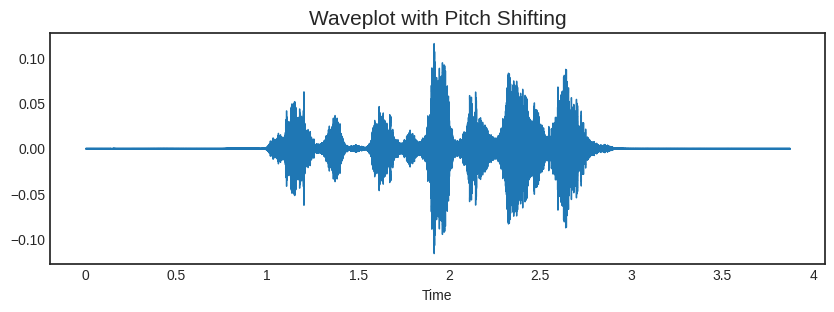

In [22]:
def pitch(data, sampling_rate, pitch_factor=0.8):
    return librosa.effects.pitch_shift(data, n_steps=int(pitch_factor * 12), sr=sampling_rate)

plt.figure(figsize=(10, 3))
x = pitch(data, sample_rate)
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Pitch Shifting', size=15)
plt.show()

# Playing the audio after pitch shifting
Audio(x, rate=sample_rate)

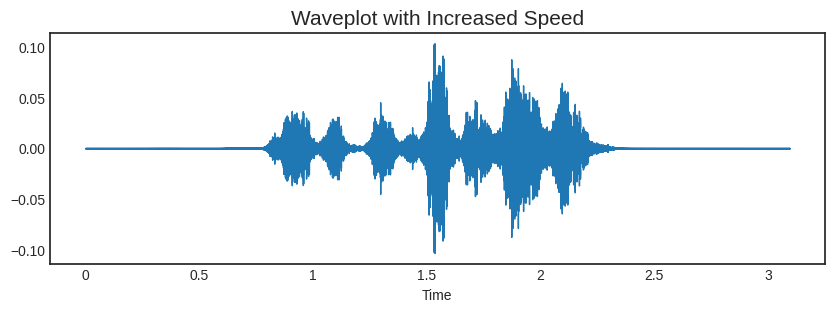

In [23]:
def higher_speed(data, sample_rate, speed_factor=1.25):
    return librosa.effects.time_stretch(y=data, rate=speed_factor)
plt.figure(figsize=(10, 3))
x = higher_speed(data, sample_rate)  # Assuming data and sample_rate are defined elsewhere
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Increased Speed', size=15)
plt.show()

# Playing the audio after increasing the speed
Audio(x, rate=sample_rate)

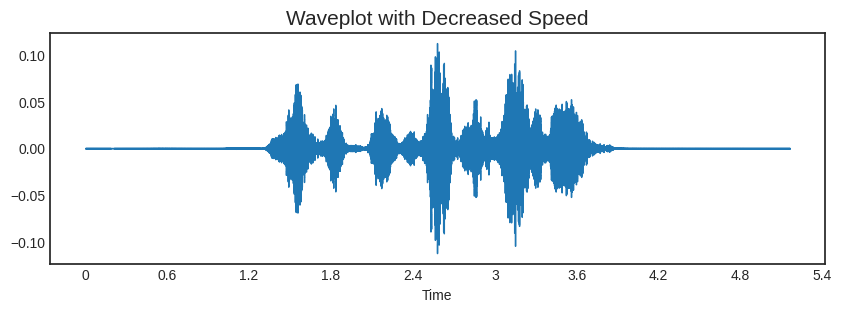

In [24]:
def lower_speed(data, speed_factor=0.75):
    return librosa.effects.time_stretch(data, rate=speed_factor)

plt.figure(figsize=(10, 3))
x = lower_speed(data)  # Assuming data and sample_rate are defined elsewhere
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Decreased Speed', size=15)
plt.show()

# Playing the audio after decreasing the speed
Audio(x, rate=sample_rate)

In [25]:
def extract_features(data):

    result = np.array([])

    #mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=42) #42 mfcc so we get frames of ~60 ms
    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=3, offset=0.5, res_type='kaiser_fast')

    #without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    #noised
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    #stretched
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3))

    #shifted
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4))

    #pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    #speed up
    higher_speed_data = higher_speed(data)
    res6 = extract_features(higher_speed_data)
    result = np.vstack((result, res6))

    #speed down
    lower_speed_data = higher_speed(data)
    res7 = extract_features(lower_speed_data)
    result = np.vstack((result, res7))

    return result

In [26]:
if not DATA_FRAMES:

    valid_emotions = ['angry', 'happy', 'neutral', 'sad']

    female_X, female_Y = [], []
    for path, emotion in zip(Females.path, Females.labels):
        if emotion in valid_emotions:
            features = get_features(path)
            # adding augmentation, get_features return a multi-dimensional array (for each augmentation),
            # so we have to use a loop to fill the df
            for elem in features:
                female_X.append(elem)
                female_Y.append(emotion)

    male_X, male_Y = [], []
    for path, emotion in zip(Males.path, Males.labels):
        if emotion in valid_emotions:
            features = get_features(path)
            for elem in features:
                male_X.append(elem)
                male_Y.append(emotion)

    print(f'Check shapes:\nFemale features: {len(female_X)}, labels: {len(female_Y)}\nMale features:   {len(male_X)}, labels: {len(male_Y)}')

#

In [27]:
def setup_dataframe(gender, features, labels):
    df = pd.DataFrame(features)
    df['labels'] = labels

    # Filter only the desired labels
    valid_labels = ['angry', 'happy', 'neutral', 'sad']
    df = df[df['labels'].isin(valid_labels)]

    df.to_csv(f'{gender}_features.csv', index=False)

    print(f'{gender} dataframe')
    df.sample(frac=1).head()

    return df

In [28]:
if not DATA_FRAMES:
    Females_Features = setup_dataframe('Female', female_X, female_Y)
else:
    Females_Features = pd.read_csv(fem_path)

In [29]:
if not DATA_FRAMES:
    Males_Features = setup_dataframe('Male', male_X, male_Y)
else:
    Males_Features = pd.read_csv(mal_path)

In [30]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [31]:
valid_labels = ['angry', 'happy', 'neutral', 'sad']

# For Females
female_X = Females_Features[Females_Features['labels'].isin(valid_labels)].iloc[:, :-1].values
female_Y = Females_Features[Females_Features['labels'].isin(valid_labels)]['labels'].values

# For Males
male_X = Males_Features[Males_Features['labels'].isin(valid_labels)].iloc[:, :-1].values
male_Y = Males_Features[Males_Features['labels'].isin(valid_labels)]['labels'].values

In [32]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()

female_Y = encoder.fit_transform(np.array(female_Y).reshape(-1,1)).toarray()
male_Y = encoder.fit_transform(np.array(male_Y).reshape(-1,1)).toarray()

In [33]:
nogender_X = np.concatenate((female_X, male_X))
nogender_Y = np.concatenate((female_Y, male_Y))

x_train, x_test, y_train, y_test = train_test_split(nogender_X, nogender_Y, random_state=0, test_size=0.20, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((41843, 58), (41843, 4), (10461, 58), (10461, 4))

In [34]:
x_trainF, x_testF, y_trainF, y_testF = train_test_split(female_X, female_Y, random_state=0, test_size=0.20, shuffle=True)
x_trainF.shape, y_trainF.shape, x_testF.shape, y_testF.shape

((23788, 58), (23788, 4), (5948, 58), (5948, 4))

In [35]:
x_trainM, x_testM, y_trainM, y_testM = train_test_split(male_X, male_Y, random_state=0, test_size=0.20, shuffle=True)
x_trainM.shape, y_trainM.shape, x_testM.shape, y_testM.shape

((18054, 58), (18054, 4), (4514, 58), (4514, 4))

In [36]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_trainF = scaler.fit_transform(x_trainF)
x_testF = scaler.transform(x_testF)

x_trainM = scaler.fit_transform(x_trainM)
x_testM = scaler.transform(x_testM)

In [37]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape , x_test.shape , y_test.shape

((41843, 58, 1), (41843, 4), (10461, 58, 1), (10461, 4))

In [38]:
x_trainF = np.expand_dims(x_trainF, axis=2)
x_testF = np.expand_dims(x_testF, axis=2)
x_trainF.shape, y_trainF.shape, x_testF.shape, y_testF.shape

((23788, 58, 1), (23788, 4), (5948, 58, 1), (5948, 4))

In [39]:
x_trainM = np.expand_dims(x_trainM, axis=2)
x_testM = np.expand_dims(x_testM, axis=2)
x_trainM.shape, y_trainM.shape, x_testM.shape, y_testM.shape

((18054, 58, 1), (18054, 4), (4514, 58, 1), (4514, 4))

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, AveragePooling1D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [41]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [42]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [43]:
with strategy.scope():

    def build_model(in_shape):

        model=Sequential()
        model.add(Conv1D(256, kernel_size=6, strides=1, padding='same', activation='relu', input_shape=(in_shape, 1)))
        model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

        model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
        model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

        model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
        model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))
        model.add(Dropout(0.2))

        model.add(Conv1D(64, kernel_size=6, strides=1, padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=4, strides = 2, padding = 'same'))

        model.add(Flatten())
        model.add(Dense(units=32, activation='relu'))
        model.add(Dropout(0.3))

        model.add(Dense(units=4, activation='softmax'))
        model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])


        return model

In [44]:
def model_build_summary(mod_dim, tr_features, val_features, val_labels):
    model = build_model(mod_dim)
    model.summary()

    score = model.evaluate(val_features, val_labels, verbose = 1)
    accuracy = 100*score[1]

    return model

In [45]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.000001)

batch_size = 32
n_epochs = 50

In [46]:
def show_graphs(history):
    epochs = [i for i in range(n_epochs)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(30,12)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()

In [47]:
total_model = model_build_summary(x_train.shape[1], x_train, x_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 256)           1792      
                                                                 
 average_pooling1d (Average  (None, 29, 256)           0         
 Pooling1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 29, 128)           196736    
                                                                 
 average_pooling1d_1 (Avera  (None, 15, 128)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 128)           98432     
                                                                 
 average_pooling1d_2 (Avera  (None, 8, 128)            0

In [48]:
female_model = model_build_summary(x_trainF.shape[1], x_trainF, x_testF, y_testF)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 58, 256)           1792      
                                                                 
 average_pooling1d_3 (Avera  (None, 29, 256)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_5 (Conv1D)           (None, 29, 128)           196736    
                                                                 
 average_pooling1d_4 (Avera  (None, 15, 128)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_6 (Conv1D)           (None, 15, 128)           98432     
                                                                 
 average_pooling1d_5 (Avera  (None, 8, 128)           

In [49]:
male_model = model_build_summary(x_trainM.shape[1], x_trainM, x_testM, y_testM)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 58, 256)           1792      
                                                                 
 average_pooling1d_6 (Avera  (None, 29, 256)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_9 (Conv1D)           (None, 29, 128)           196736    
                                                                 
 average_pooling1d_7 (Avera  (None, 15, 128)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_10 (Conv1D)          (None, 15, 128)           98432     
                                                                 
 average_pooling1d_8 (Avera  (None, 8, 128)           

In [50]:
history = total_model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
1308/1308 [==============================] - 74s 56ms/step - loss: 0.8815 - accuracy: 0.6015 - val_loss: 0.7257 - val_accuracy: 0.6780 - lr: 0.0010
Epoch 2/50
1308/1308 [==============================] - 75s 58ms/step - loss: 0.7224 - accuracy: 0.6866 - val_loss: 0.6599 - val_accuracy: 0.7154 - lr: 0.0010
Epoch 3/50
1308/1308 [==============================] - 75s 57ms/step - loss: 0.6634 - accuracy: 0.7162 - val_loss: 0.6102 - val_accuracy: 0.7342 - lr: 0.0010
Epoch 4/50
1308/1308 [==============================] - 74s 57ms/step - loss: 0.6209 - accuracy: 0.7365 - val_loss: 0.5796 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 5/50
1308/1308 [==============================] - 74s 57ms/step - loss: 0.5770 - accuracy: 0.7557 - val_loss: 0.5632 - val_accuracy: 0.7611 - lr: 0.0010
Epoch 6/50
1308/1308 [==============================] - 73s 56ms/step - loss: 0.5434 - accuracy: 0.7717 - val_loss: 0.5260 - val_accuracy: 0.7791 - lr: 0.0010
Epoch 7/50
1308/1308 [========================

In [52]:
female_history = female_model.fit(x_trainF, y_trainF, batch_size=batch_size, epochs=n_epochs, validation_data=(x_testF, y_testF), callbacks=[rlrp])

Epoch 1/50
744/744 [==============================] - 51s 68ms/step - loss: 0.0183 - accuracy: 0.9939 - val_loss: 0.1647 - val_accuracy: 0.9691 - lr: 4.0000e-04
Epoch 2/50
744/744 [==============================] - 58s 78ms/step - loss: 0.0153 - accuracy: 0.9953 - val_loss: 0.1893 - val_accuracy: 0.9662 - lr: 4.0000e-04
Epoch 3/50
744/744 [==============================] - 42s 56ms/step - loss: 0.0190 - accuracy: 0.9940 - val_loss: 0.1781 - val_accuracy: 0.9620 - lr: 4.0000e-04
Epoch 4/50
744/744 [==============================] - 42s 56ms/step - loss: 0.0190 - accuracy: 0.9945 - val_loss: 0.1725 - val_accuracy: 0.9650 - lr: 4.0000e-04
Epoch 5/50
744/744 [==============================] - 43s 57ms/step - loss: 0.0162 - accuracy: 0.9948 - val_loss: 0.1538 - val_accuracy: 0.9674 - lr: 4.0000e-04
Epoch 6/50
744/744 [==============================] - 42s 56ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.1679 - val_accuracy: 0.9669 - lr: 4.0000e-04
Epoch 7/50
744/744 [==============

In [54]:
male_history = male_model.fit(x_trainM, y_trainM, batch_size=batch_size, epochs=n_epochs, validation_data=(x_testM, y_testM), callbacks=[rlrp])

Epoch 1/50
565/565 [==============================] - 48s 86ms/step - loss: 0.0326 - accuracy: 0.9888 - val_loss: 0.3432 - val_accuracy: 0.9349 - lr: 4.0000e-04
Epoch 2/50
565/565 [==============================] - 42s 74ms/step - loss: 0.0309 - accuracy: 0.9900 - val_loss: 0.3663 - val_accuracy: 0.9331 - lr: 4.0000e-04
Epoch 3/50
565/565 [==============================] - 31s 56ms/step - loss: 0.0331 - accuracy: 0.9890 - val_loss: 0.3785 - val_accuracy: 0.9346 - lr: 4.0000e-04
Epoch 4/50
565/565 [==============================] - 32s 57ms/step - loss: 0.0236 - accuracy: 0.9928 - val_loss: 0.3591 - val_accuracy: 0.9384 - lr: 4.0000e-04
Epoch 5/50
565/565 [==============================] - 33s 58ms/step - loss: 0.0280 - accuracy: 0.9907 - val_loss: 0.3967 - val_accuracy: 0.9333 - lr: 4.0000e-04
Epoch 6/50
565/565 [==============================] - 33s 58ms/step - loss: 0.0269 - accuracy: 0.9910 - val_loss: 0.3580 - val_accuracy: 0.9402 - lr: 4.0000e-04
Epoch 7/50
565/565 [==============

In [55]:
# genderless
score = total_model.evaluate(x_train,y_train, verbose = 0)
print("Mixed-gender emotions training Accuracy: {0:.2%}".format(score[1]))

score = total_model.evaluate(x_test, y_test, verbose=0)
print("Mixed-gender emotions testing Accuracy: {0:.2%}".format(score[1]))

Mixed-gender emotions training Accuracy: 98.84%
Mixed-gender emotions testing Accuracy: 92.95%


In [56]:
score = female_model.evaluate(x_trainF,y_trainF, verbose = 0)
print("Female emotions training Accuracy: {0:.2%}".format(score[1]))

score = female_model.evaluate(x_testF, y_testF, verbose=0)
print("Female emotions testing Accuracy: {0:.2%}".format(score[1]))

Female emotions training Accuracy: 99.98%
Female emotions testing Accuracy: 97.02%


In [57]:
score = male_model.evaluate(x_trainM,y_trainM, verbose = 0)
print("Male emotions training Accuracy: {0:.2%}".format(score[1]))

score = male_model.evaluate(x_testM, y_testM, verbose=0)
print("Male emotions testing Accuracy: {0:.2%}".format(score[1]))

Male emotions training Accuracy: 100.00%
Male emotions testing Accuracy: 94.66%


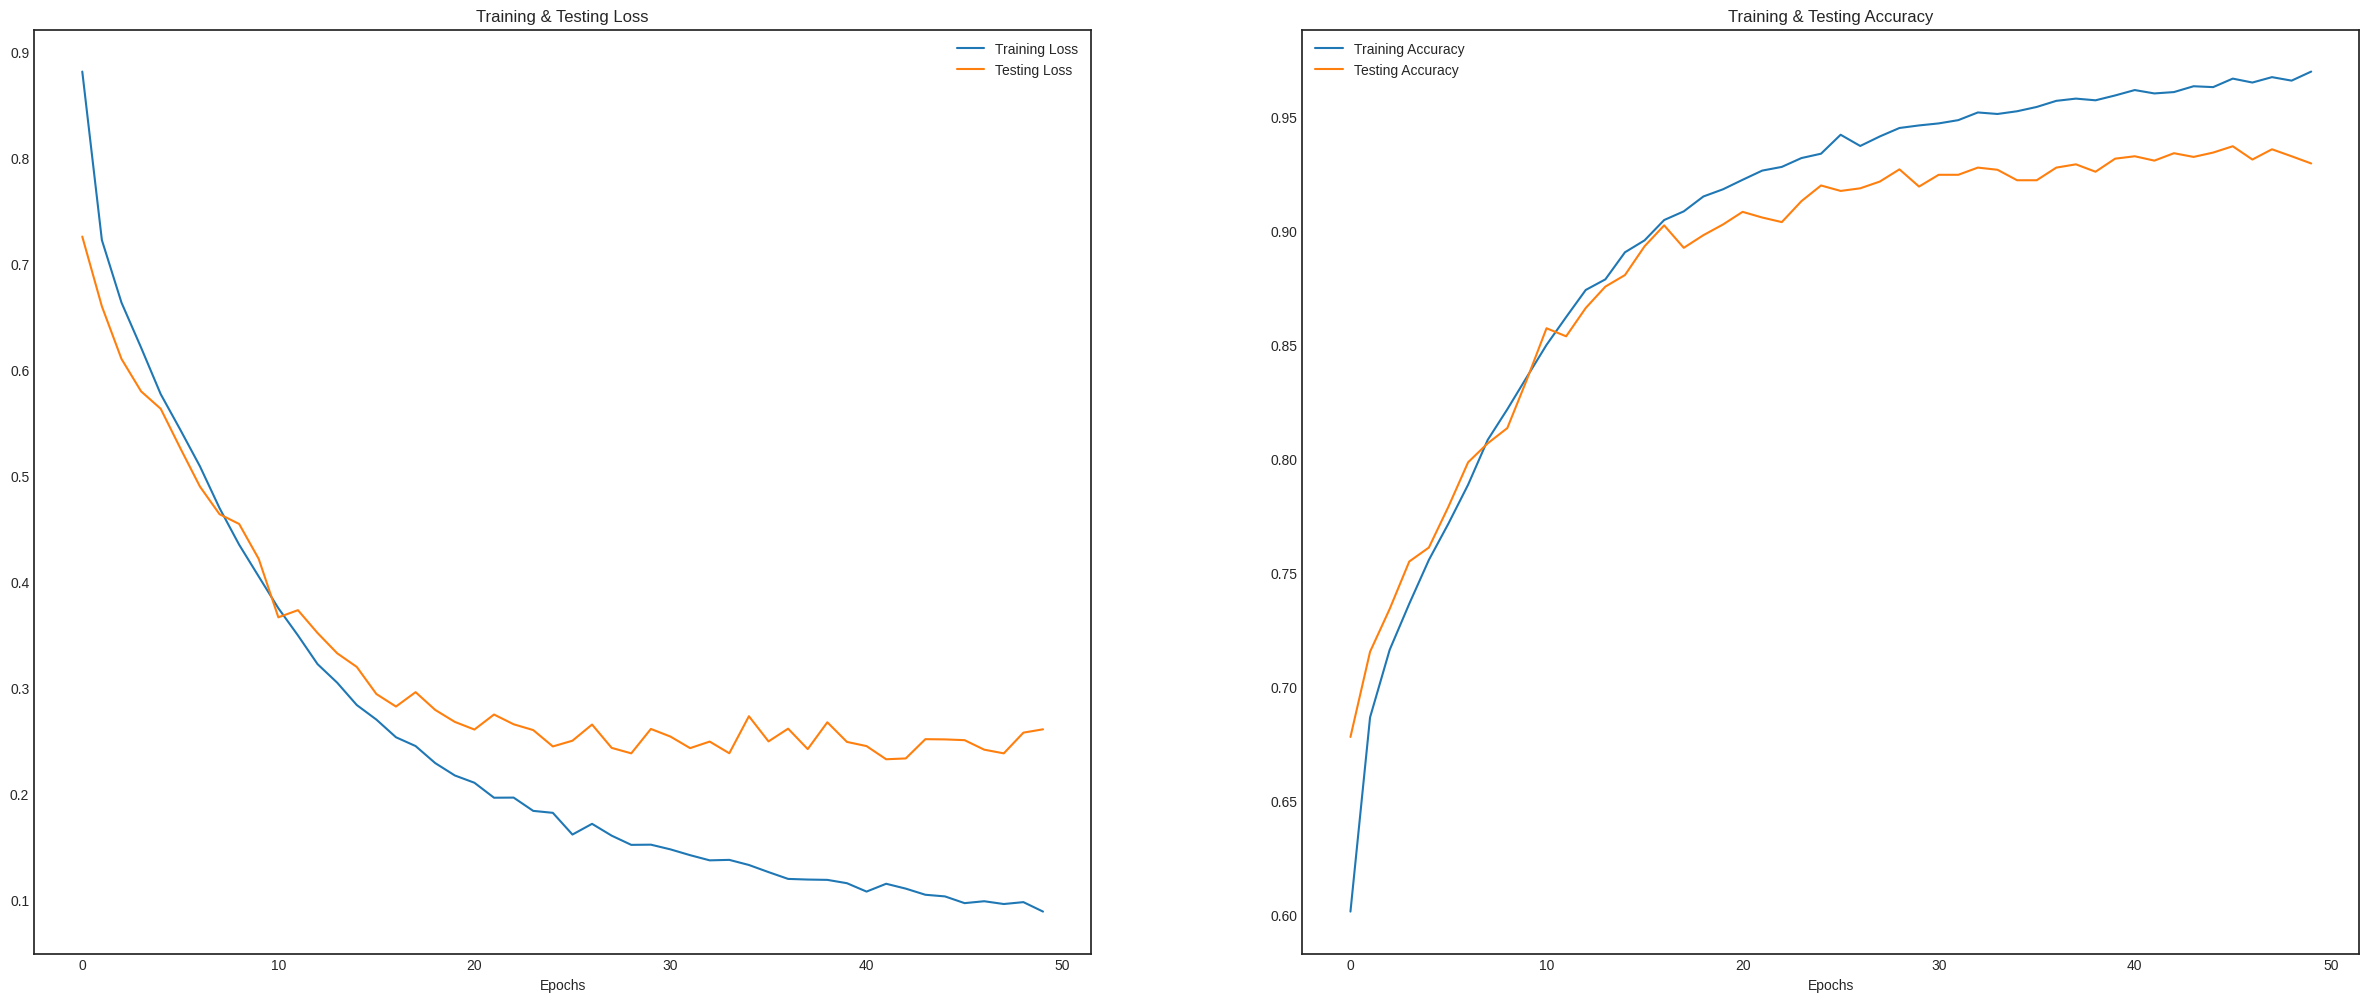

In [58]:
show_graphs(history)

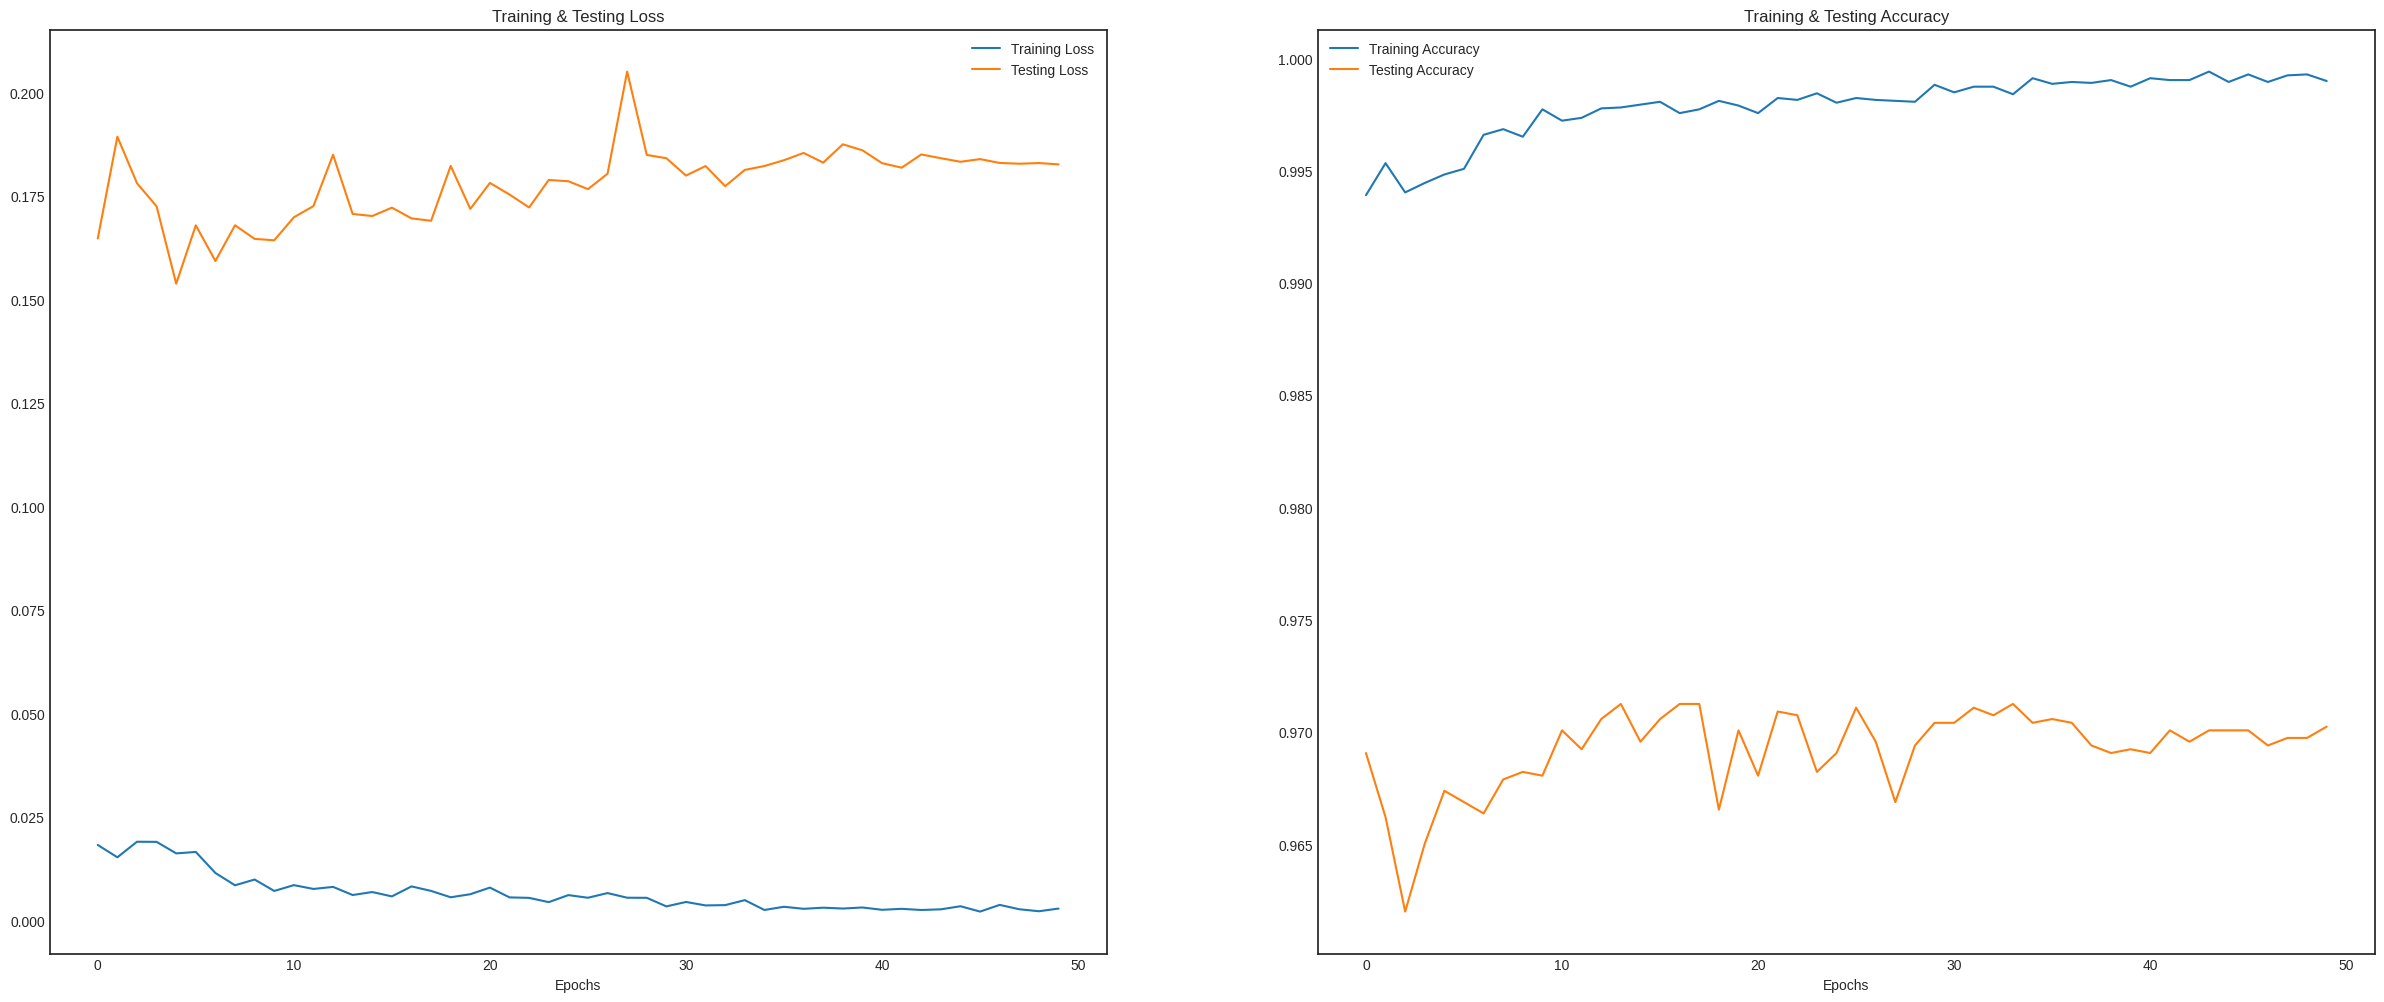

In [59]:
show_graphs(female_history)

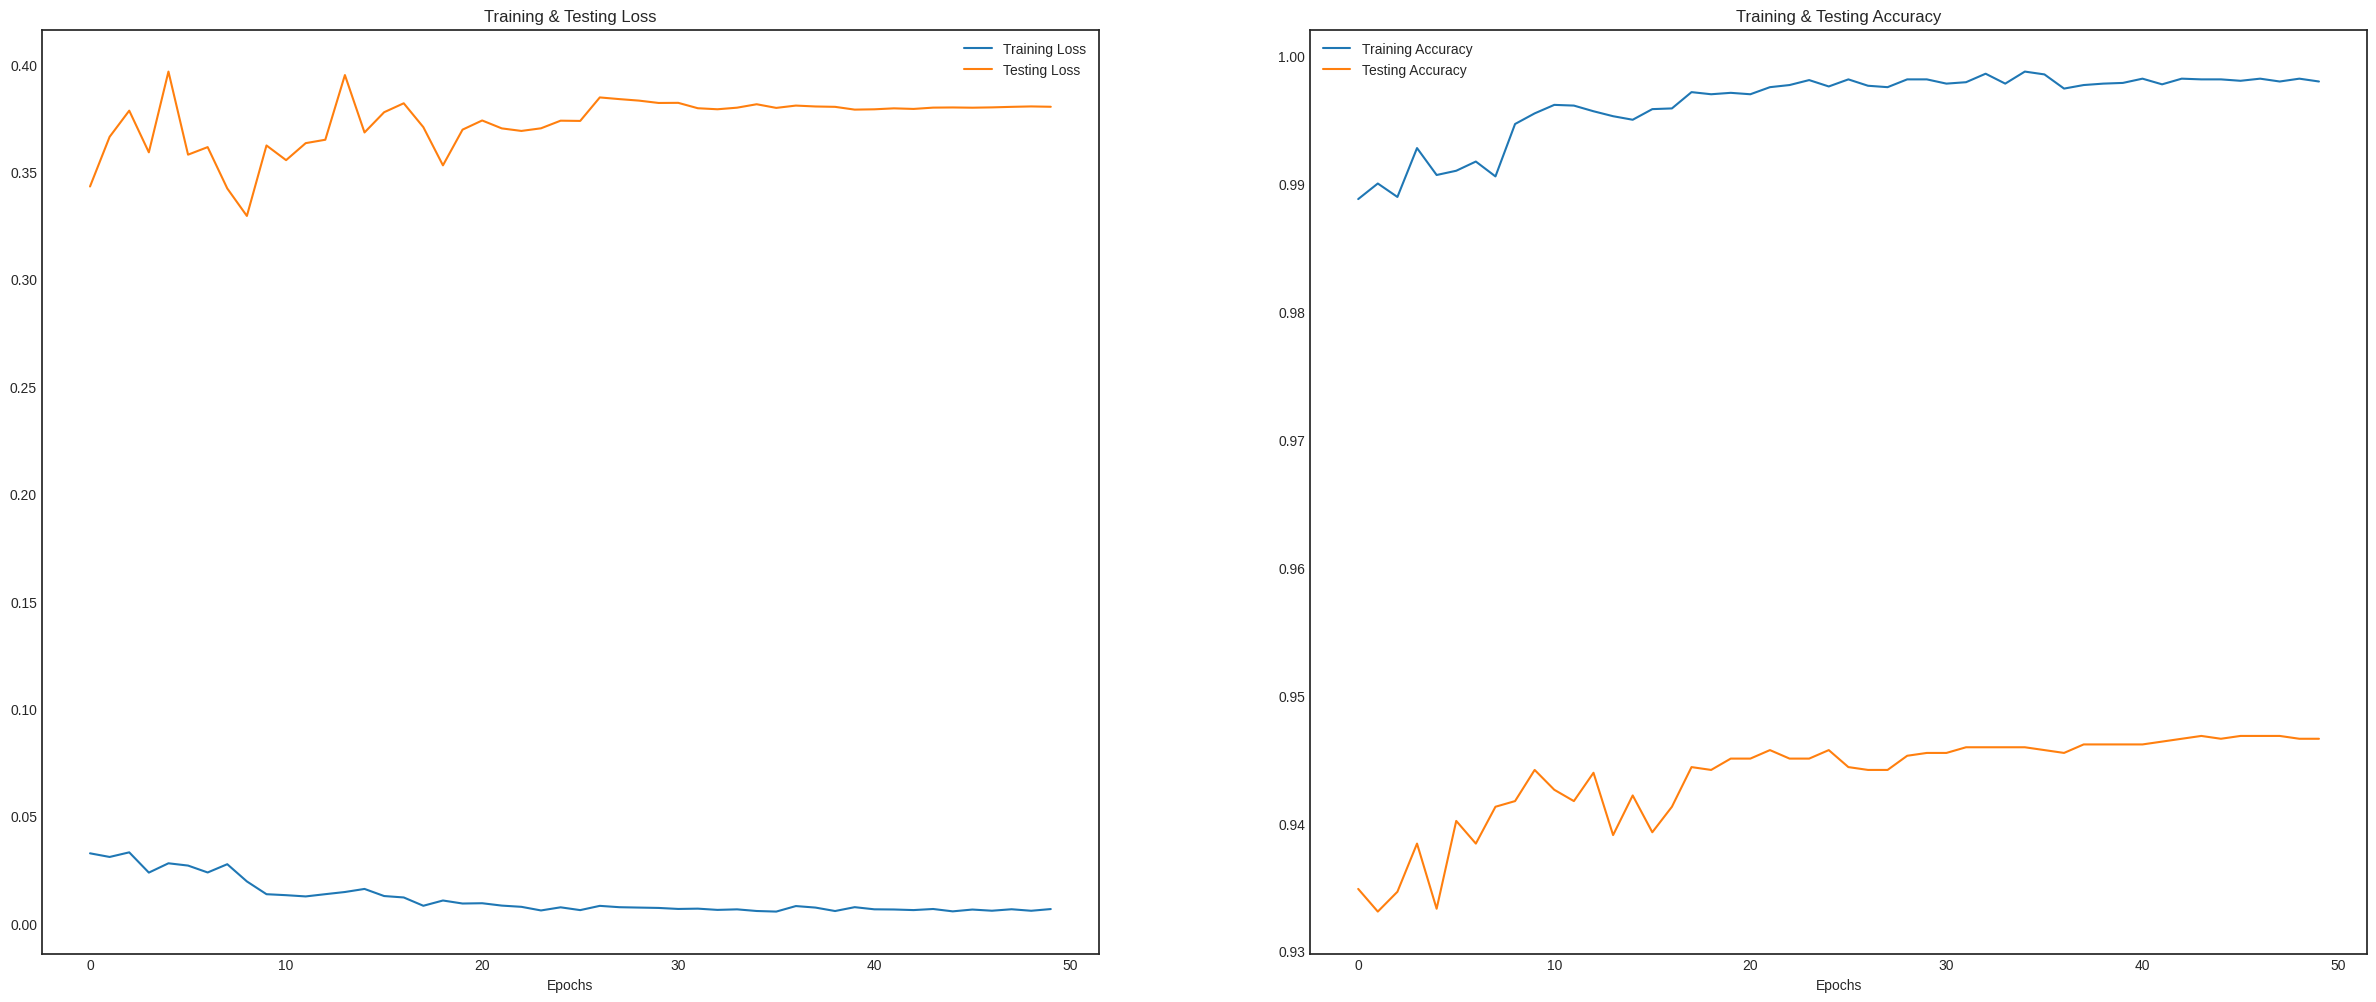

In [60]:
show_graphs(male_history)

In [61]:
# predicting on test data.
pred_test = female_model.predict(x_testF)
y_pred = encoder.inverse_transform(pred_test)
y_test_ = encoder.inverse_transform(y_testF)

186/186 [==============================] - 4s 19ms/step


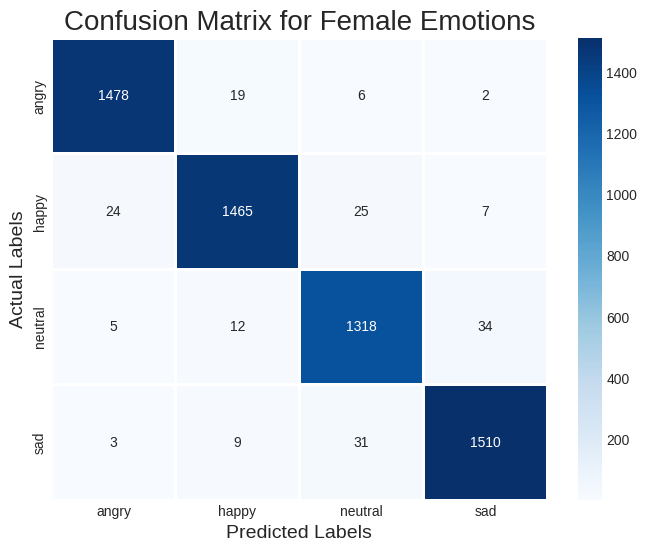

In [62]:
cm = confusion_matrix(y_test_, y_pred)
plt.figure(figsize = (8, 6))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix for Female Emotions', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [63]:
# predicting on test data.
pred_test = male_model.predict(x_testM)
y_pred = encoder.inverse_transform(pred_test)
y_test_ = encoder.inverse_transform(y_testM)

142/142 [==============================] - 3s 19ms/step


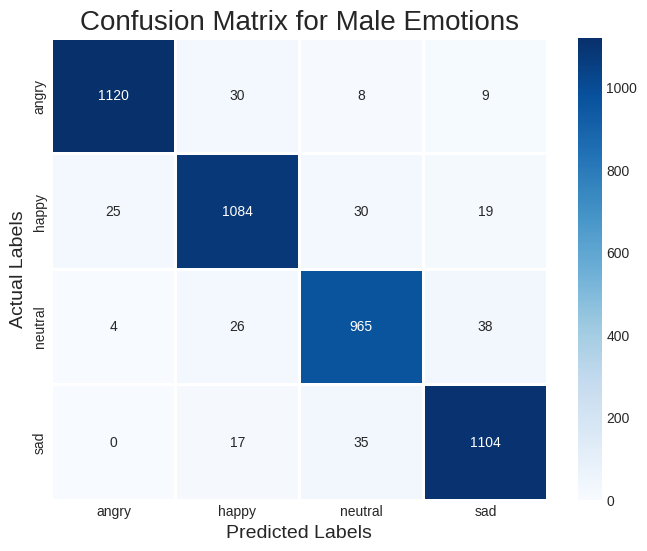

In [64]:
cm = confusion_matrix(y_test_, y_pred)
plt.figure(figsize = (8, 6))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix for Male Emotions', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()